In [ ]:
#!/usr/bin/env python
# -*- coding:utf-8 -*-
__author__ = 'Ning Shi'
__email__ = 'mrshininnnnn@gmail.com'

# Word Surprisal Correlates with Sentential Contradiction in LLMs

In [20]:
# built-in
import os

# public
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from sklearn.metrics import roc_auc_score

# private
from src.helper import (
    set_random_seed
    , get_device
    , load_json_gzip
    , is_content_word
)
from config import Config

%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# I/O

In [21]:
config = Config()
for k,v in config.__dict__.items():
    print(f'{k}: {v}')

set_random_seed(config.seed)
config.device = get_device()

print(f"Using device: {config.device}")

seed: 0
llm: Qwen3-4B
beam_depth: 10
temp: True
llm_name: Qwen3-4B
CURR_PATH: ./
RESOURCE_PATH: ./res
DATA_PATH: ./res/data
RESULTS_PATH: ./res/results
LLMS_PATH: ./res/llms
LLM_PATH: ./res/llms/Qwen3-4B
LOG_PATH: ./res/logs
Using device: mps


In [22]:
# input file

# bAbI
input_json = os.path.join(config.RESULTS_PATH, config.llm_name, 'babi_120_con.json.gz')
ori_data = os.path.join(config.DATA_PATH, 'babi_120_con.tsv')

In [23]:
ori_data_df = pd.read_csv(ori_data, sep='\t')
data = load_json_gzip(input_json)
ori_data_df.head()

,premise,hypothesis,label
0,Daniel is in the bathroom.,Daniel is in the bedroom.,True
1,Daniel is in the garden.,Daniel is in the driveway.,True
2,Daniel is in the bedroom.,Daniel is in the driveway.,True
3,Sandra is in the garden.,Sandra is in the bedroom.,True
4,John is in the bathroom.,John is in the garden.,True


In [24]:
ori_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   premise     120 non-null    object
 1   hypothesis  120 non-null    object
 2   label       120 non-null    bool  
dtypes: bool(1), object(2)
memory usage: 2.1+ KB


In [25]:
ori_ps = ori_data_df['premise'].tolist()
ori_hs = ori_data_df['hypothesis'].tolist()
ori_ys = ori_data_df['label'].tolist()

In [26]:
ps = [item['premise'] for _, item in data.items()]
hs = [item['hypothesis'] for _, item in data.items()]
ys = ori_data_df['label'].tolist()

# Baseline

In [27]:
# majority voting baseline
true_size = (np.array(ys) == True).sum()
false_size = (np.array(ys) == False).sum()
true_size, false_size

(60, 60)

In [28]:
baseline_ys = [False] * len(ys)
baseline_acc = (np.array(baseline_ys) == np.array(ys)).sum() / len(ys)
baseline_acc

0.5

In [29]:
# length baseline
accs = []
h_lengths = [len(h) for h in hs]
for i in range(0,40): 
    length_ys = [1 if l > i else 0 for l in h_lengths]
    acc = (np.array(length_ys) == np.array(ys)).sum() / len(ys)
    accs.append(acc)

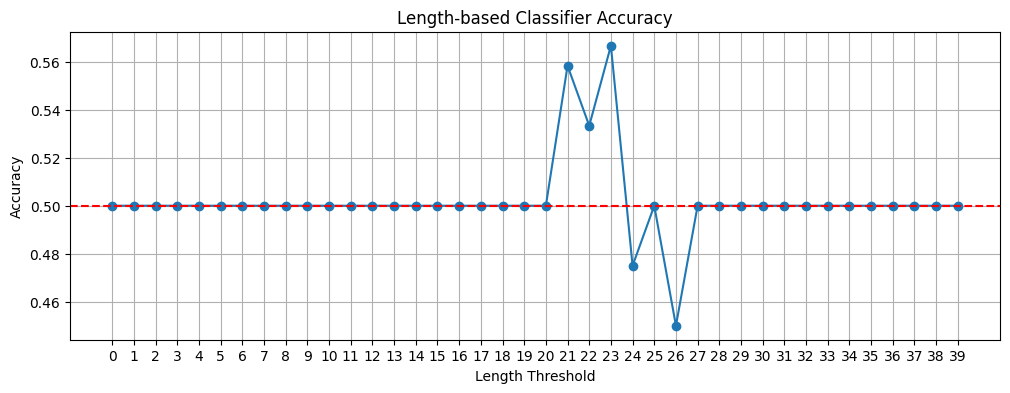

In [30]:
# show the line chart
plt.figure(figsize=(12, 4))
plt.plot(range(0,40), accs, marker='o')
# 50 baseline
plt.axhline(y=0.5, color='r', linestyle='--', label='Majority Baseline')
plt.title('Length-based Classifier Accuracy')
plt.xlabel('Length Threshold')
plt.ylabel('Accuracy')
plt.xticks(range(0, 40))
plt.grid()
plt.show()

# CON2LM

## Last Word Surprisal

In [31]:
# get last word index
h_last_word_idxes = []
for h in hs:
    tokens = word_tokenize(h)
    last_word = ''
    last_word_idx = -1
    reversed_tokens = list(reversed(tokens))
    for token in reversed_tokens:
        if token.isalpha():
            last_word_idx = len(tokens) - reversed_tokens.index(token) - 1
            break
    h_last_word_idxes.append(last_word_idx)

In [32]:
ph_last_word_surprisals = []
ph_last_top1_surprisals = []
h_ws = []
ph_top1_ws = []
for (idx, item), h_last_word_idx in zip(data.items(), h_last_word_idxes):
    h_w = word_tokenize(item['hypothesis'])[h_last_word_idx]
    h_ws.append(h_w)
    ph_last_word_surprisals.append(item['surprisals_with_premise'][h_last_word_idx])
    ph_top1_w = item['next_words_with_premise'][h_last_word_idx]
    ph_top1_ws.append(ph_top1_w)
    ph_last_top1_surprisals.append(item['next_surprisals_with_premise'][h_last_word_idx])
    # break

In [33]:
accs = []
for tao in range(15):
    ys_ = [s > tao for s in ph_last_word_surprisals]
    accuracy = (np.array(ys) == np.array(ys_)).sum() / len(ys)
    accs.append(accuracy)

In [34]:
for idx, acc in enumerate(accs):
    marker = " ← BEST" if idx == np.argmax(accs) else ""
    print(f"Tao {idx}: {acc:.4f}{marker}")
print(f"\nBest: {np.max(accs):.4f} at index {np.argmax(accs)}")

Tao 0: 0.5000
Tao 1: 0.7583
Tao 2: 0.7833
Tao 3: 0.8333
Tao 4: 0.8417 ← BEST
Tao 5: 0.8167
Tao 6: 0.7750
Tao 7: 0.7583
Tao 8: 0.7750
Tao 9: 0.8000
Tao 10: 0.8250
Tao 11: 0.8167
Tao 12: 0.8000
Tao 13: 0.7417
Tao 14: 0.7000

Best: 0.8417 at index 4


## Max Word Surprisal

In [35]:
accs = []
for tao in tqdm(range(15)):
    ys_ = []
    for idx, item in data.items():
        s_word = None
        ph_surprisal = None
        h_words = word_tokenize(item['hypothesis'])
        ph_surprisals = item['surprisals_with_premise']
        pos_tags = pos_tag(h_words)
        scores = []

        # Only check surprisal for content words
        for i, (word, pos) in enumerate(pos_tags):
            if is_content_word(word, pos) and ph_surprisals[i] != float('inf'):
                scores.append(ph_surprisals[i])

        score = max(scores)
        # print(score)
        if score > tao:
            y_ = True
        else:
            y_ = False
        ys_.append(y_)

    accuracy = (np.array(ys) == np.array(ys_)).sum() / len(ys)
    accs.append(accuracy)

100%|██████████| 15/15 [00:00<00:00, 105.74it/s]


In [36]:
for idx, acc in enumerate(accs):
    marker = " ← BEST" if idx == np.argmax(accs) else ""
    print(f"Tao {idx}: {acc:.4f}{marker}")
print(f"\nBest: {np.max(accs):.4f} at index {np.argmax(accs)}")

Tao 0: 0.5000
Tao 1: 0.5000
Tao 2: 0.5000
Tao 3: 0.5500
Tao 4: 0.6417
Tao 5: 0.6667
Tao 6: 0.6333
Tao 7: 0.6417
Tao 8: 0.6917
Tao 9: 0.7417
Tao 10: 0.8167 ← BEST
Tao 11: 0.8167
Tao 12: 0.8000
Tao 13: 0.7417
Tao 14: 0.7000

Best: 0.8167 at index 10


# Last Word Surprisal Difference

In [37]:
accs = []
sur_diff = [i - j for i, j in zip(ph_last_word_surprisals, ph_last_top1_surprisals)]
for tao in range(15):
# for tao in np.arange(2, 5.25, 0.25):
    ys_ = [s > tao for s in sur_diff]
    accuracy = (np.array(ys) == np.array(ys_)).sum() / len(ys)
    accs.append(accuracy)

In [38]:
for idx, acc in enumerate(accs):
    marker = " ← BEST" if idx == np.argmax(accs) else ""
    print(f"Tao {idx}: {acc:.4f}{marker}")
print(f"\nBest: {np.max(accs):.4f} at index {np.argmax(accs)}")

Tao 0: 0.7583
Tao 1: 0.7667
Tao 2: 0.7917
Tao 3: 0.8417 ← BEST
Tao 4: 0.8417
Tao 5: 0.8000
Tao 6: 0.7583
Tao 7: 0.7500
Tao 8: 0.7833
Tao 9: 0.8083
Tao 10: 0.8000
Tao 11: 0.8083
Tao 12: 0.7917
Tao 13: 0.7083
Tao 14: 0.6833

Best: 0.8417 at index 3


# Word Surprisal Mean

In [39]:
accs = []
for tao in tqdm(range(15)):
    ys_ = []
    for idx, item in data.items():
        s_word = None
        ph_surprisal = None
        h_words = word_tokenize(item['hypothesis'])
        ph_surprisals = item['surprisals_with_premise']
        pos_tags = pos_tag(h_words)
        scores = []

        # Only check surprisal for content words
        for i, (word, pos) in enumerate(pos_tags):
            if is_content_word(word, pos) and ph_surprisals[i] != float('inf'):
                scores.append(ph_surprisals[i])

        score = np.mean(scores)
        if score > tao:
            y_ = True
        else:
            y_ = False
        ys_.append(y_)

    accuracy = (np.array(ys) == np.array(ys_)).sum() / len(ys)
    accs.append(accuracy)

100%|██████████| 15/15 [00:00<00:00, 102.82it/s]


In [40]:
for idx, acc in enumerate(accs):
    marker = " ← BEST" if idx == np.argmax(accs) else ""
    print(f"Tao {idx}: {acc:.4f}{marker}")
print(f"\nBest: {np.max(accs):.4f} at index {np.argmax(accs)}")

Tao 0: 0.5000
Tao 1: 0.5000
Tao 2: 0.6000
Tao 3: 0.6833
Tao 4: 0.7083
Tao 5: 0.7250
Tao 6: 0.7750
Tao 7: 0.8083 ← BEST
Tao 8: 0.7333
Tao 9: 0.6583
Tao 10: 0.6250
Tao 11: 0.5833
Tao 12: 0.5417
Tao 13: 0.5000
Tao 14: 0.5000

Best: 0.8083 at index 7


# ROC-AUC

In [41]:
# baseline
word_lengths = [len(h) for h in hs]
roc_auc_score(ys, word_lengths)

0.5273611111111112

In [42]:
# Last Direct
last_direct_scores = ph_last_word_surprisals.copy()
last_direct_scores = roc_auc_score(ys, last_direct_scores)

# Last Relative
last_relative_scores = [i - j for i, j in zip(ph_last_word_surprisals, ph_last_top1_surprisals)]
last_relative_scores = roc_auc_score(ys, last_relative_scores)

# Mean Direct
mean_direct_scores = []
for idx, item in data.items():
    h_words = word_tokenize(item['hypothesis'])
    ph_surprisals = item['surprisals_with_premise']
    pos_tags = pos_tag(h_words)
    scores = []

    # Only check surprisal for content words
    for i, (word, pos) in enumerate(pos_tags):
        if is_content_word(word, pos) and ph_surprisals[i] != float('inf'):
            scores.append(ph_surprisals[i])
    score = np.mean(scores)
    mean_direct_scores.append(score)
mean_direct_scores = roc_auc_score(ys, mean_direct_scores)

# Mean Relative
mean_relative_scores = []
for idx, item in data.items():
    h_words = word_tokenize(item['hypothesis'])
    ph_surprisals = item['surprisals_with_premise']
    ph_top1_surprisals = item['next_surprisals_with_premise']
    pos_tags = pos_tag(h_words)
    scores = []

    # Only check surprisal for content words
    for i, (word, pos) in enumerate(pos_tags):
        if is_content_word(word, pos) and ph_surprisals[i] != float('inf') and ph_top1_surprisals[i] != float('inf'):
            scores.append(ph_surprisals[i] - ph_top1_surprisals[i])
    score = np.mean(scores)
    mean_relative_scores.append(score)
mean_relative_scores = roc_auc_score(ys, mean_relative_scores)

# Max Direct
max_direct_scores = []
for idx, item in data.items():
    h_words = word_tokenize(item['hypothesis'])
    ph_surprisals = item['surprisals_with_premise']
    pos_tags = pos_tag(h_words)
    scores = []

    # Only check surprisal for content words
    for i, (word, pos) in enumerate(pos_tags):
        if is_content_word(word, pos) and ph_surprisals[i] != float('inf'):
            scores.append(ph_surprisals[i])
    score = np.max(scores)
    max_direct_scores.append(score)
max_direct_scores = roc_auc_score(ys, max_direct_scores)

# Max Relative
max_relative_scores = []
for idx, item in data.items():
    h_words = word_tokenize(item['hypothesis'])
    ph_surprisals = item['surprisals_with_premise']
    ph_top1_surprisals = item['next_surprisals_with_premise']
    pos_tags = pos_tag(h_words)
    scores = []

    # Only check surprisal for content words
    for i, (word, pos) in enumerate(pos_tags):
        if is_content_word(word, pos) and ph_surprisals[i] != float('inf') and ph_top1_surprisals[i] != float('inf'):
            # print(word)
            scores.append(ph_surprisals[i] - ph_top1_surprisals[i])
    score = np.max(scores)
    max_relative_scores.append(score)
max_relative_scores = roc_auc_score(ys, max_relative_scores)

print(f'Last Direct AUC: {last_direct_scores:.4f}; Last Relative AUC: {last_relative_scores:.4f}; Mean Direct AUC: {mean_direct_scores:.4f}; Mean Relative AUC: {mean_relative_scores:.4f}; Max Direct AUC: {max_direct_scores:.4f}; Max Relative AUC: {max_relative_scores:.4f}')

Last Direct AUC: 0.9231; Last Relative AUC: 0.9222; Mean Direct AUC: 0.8686; Mean Relative AUC: 0.8708; Max Direct AUC: 0.8393; Max Relative AUC: 0.8418
